# **Reading The data from google drive**

In [ ]:
!pip install PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':"1FUXSmzQXl4lUjHE6vDvXPtAmuo_azcIo"})
downloaded.GetContentFile('train.zip')

In [ ]:
!unzip "train.zip" -d  ""

Archive:  train.zip
  inflating: train.csv               


# **Preprocessing**

Here, I've read the data, converted its pixels column's values to matrixes with (8, 48, 1) shape, then split it to train and validation parts. In the end, I've flipped the train part horizontally and vertically for data augmentation.

In [ ]:
import numpy as np

In [ ]:
import tensorflow as tf

In [ ]:
import pandas as pd
data = pd.read_csv('train.csv')

In [ ]:
data

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...
28704,2,84 85 85 85 85 85 85 85 86 86 86 87 86 86 91 9...
28705,0,114 112 113 113 111 111 112 113 115 113 114 11...
28706,4,74 81 87 89 95 100 98 93 105 120 127 133 146 1...
28707,0,222 227 203 90 86 90 84 77 94 87 99 119 134 14...


**Creating Matrixes**

In [ ]:
def get_int_list(X, r, ind, width=48, height=48):
  s = r.split(" ")

  for i in range(len(s)):
    row = i // width
    column = i % width 

    X[ind][row][column][0] = int(s[i]) / 255

In [ ]:
X = np.zeros(shape=(len(data), 48, 48, 1))

In [ ]:
for i in range(len(data)):
  get_int_list(X, data.loc[i, 'pixels'], i)

In [ ]:
y = np.array(data['emotion'])

**Spliting the data**

In [ ]:
from sklearn.model_selection import train_test_split
train_images_f, test_images, train_labels_f, test_labels = train_test_split(X, y, test_size=0.15, random_state=42)

**Augmenting the train part**

In [ ]:
train_images_r = np.flip(train_images_f, 2)
train_images_u = np.flip(train_images_f, 1)
train_images_ra = np.append(train_images_f, train_images_r, axis=0)
train_images = np.append(train_images_ra, train_images_u, axis=0)

train_labels_r = np.append(train_labels_f, train_labels_f)
train_labels = np.append(train_labels_f, train_labels_r)

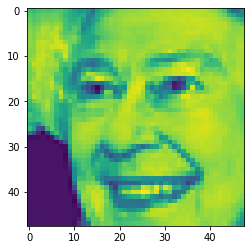

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(train_images[10].reshape((48, 48)))

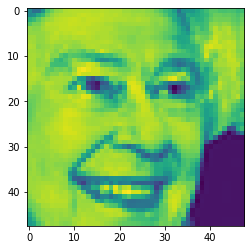

In [ ]:
plt.imshow(train_images[train_images_f.shape[0] + 10].reshape((48, 48)))

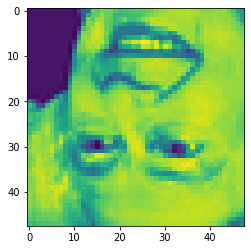

In [ ]:
plt.imshow(train_images[train_images_f.shape[0] * 2 + 10].reshape((48, 48)))

In [ ]:
train_labels[205]

0

In [ ]:
train_labels[train_labels_f.shape[0] + 205]

0

In [ ]:
train_labels[train_labels_f.shape[0] * 2 + 205]

0

# **The model**

In this part, I first created the model architecture, then called the fit function with trains the model on the dataset. In the end, I've plotted the train and validation accuracy changes during the training.

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib
from tensorflow import keras

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU

**Creating the model**

In [ ]:
model = Sequential()

model.add(Conv2D(16, [3, 3], padding='same', input_shape=train_images[0].shape))
model.add(LeakyReLU(0.1))
model.add(Conv2D(32, [3, 3], padding='same'))
model.add(LeakyReLU(0.1))
model.add(MaxPooling2D([2, 2]))
model.add(Dropout(0.25))

model.add(Conv2D(32, [3, 3], padding='same'))
model.add(LeakyReLU(0.1))
model.add(Conv2D(64, [3, 3], padding='same'))
model.add(LeakyReLU(0.1))
model.add(MaxPooling2D([2, 2]))
model.add(Dropout(0.25))

model.add(Conv2D(128, [3, 3], padding='same'))
model.add(LeakyReLU(0.1))
model.add(MaxPooling2D([2, 2]))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Dropout(0.3))
model.add(LeakyReLU(0.1))

model.add(Dense(256))
model.add(Dropout(0.3))
model.add(LeakyReLU(0.1))

model.add(Dense(7))
model.add(Activation('softmax'))

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 48, 48, 16)        160       
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 48, 48, 16)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 48, 48, 32)        4640      
                                                                 
 leaky_re_lu_29 (LeakyReLU)  (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 24, 24, 32)        0         
                                                      

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = model.fit(train_images, train_labels, epochs=32, validation_data=(test_images, test_labels))

# model.save_weights('ws.h5')

Epoch 1/32


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


2288/2288 [==============================] - 39s 17ms/step - loss: 1.6467 - accuracy: 0.3344 - val_loss: 1.3302 - val_accuracy: 0.4925
Epoch 2/32
2288/2288 [==============================] - 38s 17ms/step - loss: 1.3377 - accuracy: 0.4824 - val_loss: 1.2021 - val_accuracy: 0.5421
Epoch 3/32
2288/2288 [==============================] - 38s 16ms/step - loss: 1.2452 - accuracy: 0.5219 - val_loss: 1.1763 - val_accuracy: 0.5519
Epoch 4/32
2288/2288 [==============================] - 38s 17ms/step - loss: 1.1846 - accuracy: 0.5462 - val_loss: 1.1219 - val_accuracy: 0.5746
Epoch 5/32
2288/2288 [==============================] - 38s 17ms/step - loss: 1.1527 - accuracy: 0.5616 - val_loss: 1.0917 - val_accuracy: 0.5846
Epoch 6/32
2288/2288 [==============================] - 38s 17ms/step - loss: 1.1143 - accuracy: 0.5743 - val_loss: 1.0815 - val_accuracy: 0.5932
Epoch 7/32
2288/2288 [==============================] - 38s 17ms/step - loss: 1.0963 - accuracy: 0.5824 - val_loss: 1.0788 - val_accura

**Plotting the changes of the model in the accuracy of the training and validation set.**

135/135 - 1s - loss: 1.0959 - accuracy: 0.6074 - 800ms/epoch - 6ms/step


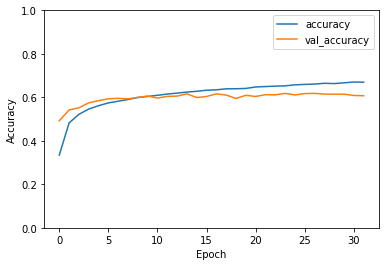

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='best')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [ ]:
def prd(i):
  return np.argmax(model.predict(test_images[i:i+1]))

In [ ]:
prd(10)

3

In [ ]:
test_labels[10]

3